In [ ]:
import pandas as pd
import psycopg2
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In [3]:
DB_HOST = 'localhost'
DB_NAME = 'tv_streaming'
DB_USER = 'user'
DB_PASS = 'password'
DB_PORT = '9999'

def parse_sql(query_path: str) -> str:
    try:
        with open(query_path, 'r') as file:
            query = file.read()
        return query
    except Exception as e:
        print(f"Error reading SQL file: {e}")

In [4]:
try:
    with psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS,
        port=DB_PORT
    ) as conn:
        ads_linked_to_purchases_df = pd.read_sql(parse_sql("sql/ads_linked_to_purchases.sql"), conn)
except Exception as e:
    print(e)

C:\Users\zweifeladmin\AppData\Local\Temp\ipykernel_13980\727292824.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ads_linked_to_purchases_df = pd.read_sql(parse_sql("sql/ads_linked_to_purchases.sql"), conn)


In [5]:
ads_linked_to_purchases_df.describe()

,purchase_value,total_decayed_linear_tv_credit,total_decayed_streaming_app_a_credit
count,185.000000,185.000000,185.000000
mean,229.572378,0.136772,2.679227
std,137.516829,0.299603,2.276448
min,11.580000,0.000000,0.000000
25%,113.520000,0.000000,0.769098
50%,210.790000,0.000000,2.290176
75%,352.420000,0.076310,4.021504
max,496.690000,1.463230,10.535412


In [6]:
# Features (X): Time-decayed credits from different platforms
# Target (y): purchase_value
features = ['total_decayed_linear_tv_credit', 'total_decayed_streaming_app_a_credit']
target = 'purchase_value'

X = ads_linked_to_purchases_df[features]
y = ads_linked_to_purchases_df[target]

# Simple imputation for safety, though we already used COALESCE(..,0) in the SQL query
X = X.fillna(0)
y = y.fillna(y.median() if not y.isnull().all() else 0) # don't want to impute with 0 since it could be an unlogged legitimate purchase

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")

Features (X) shape: (185, 2)
Target (y) shape: (185,)

Training set size: 148 samples, 2 features
Test set size: 37 samples, 2 features


In [7]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

print("--- Model Coefficients (scikit-learn) ---")
coefficients = pd.DataFrame(data=linreg_model.coef_, index=X_train.columns, columns=['Coefficient'])
print(coefficients)
print(f"Intercept: {linreg_model.intercept_:.4f}")

--- Model Coefficients (scikit-learn) ---
                                      Coefficient
total_decayed_linear_tv_credit          65.667801
total_decayed_streaming_app_a_credit    -0.145104
Intercept: 215.6293


In [8]:
# Using statsmodels OLS for more detailed statistics (scikit-learn LinearRegression uses OLS as a loss function by default)
X_train_const = sm.add_constant(X_train) # statsmodels needs an intercept term
model_sm = sm.OLS(y_train, X_train_const).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:         purchase_value   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.618
Date:                Sun, 11 May 2025   Prob (F-statistic):              0.202
Time:                        14:56:14   Log-Likelihood:                -938.71
No. Observations:                 148   AIC:                             1883.
Df Residuals:                     145   BIC:                             1892.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [9]:
# confirm that statsmodels and sklearn coefficients are the same
assert np.allclose(linreg_model.coef_, model_sm.params[1:]), "Coefficients from sklearn and statsmodels do not match!"

R-squared is pretty low at 0.022 (even to the training set here), in other words, this linear model based on time-weighted credit isn't very good at predicting purchase value. It only explains 2.2% of the variation. The F-statistic is also above 0.05 (p = 0.202 > 0.05), so the coefficients are more likely to be 0 than not. But, lets test it on the test set anyway

In [10]:
y_pred_train = linreg_model.predict(X_train)
y_pred_test = linreg_model.predict(X_test)

print("--- Model Performance ---")
print(f"Train R-squared: {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R-squared: {r2_score(y_test, y_pred_test):.4f}")

# MAE (Mean Absolute Error) might make sense here since we might expect some customers to be big spenders while most don't spend anything at all
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")

# RMSE for comparison.
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")


--- Model Performance ---
Train R-squared: 0.0218
Test R-squared: -0.0593
Train MAE: 119.1840
Test MAE: 109.2719
Train RMSE: 137.5073
Test RMSE: 131.1321


As it turns out, the R-squared on the test set is -0.0593, which is hilarously bad. This simply means predicting the constant mean was better than using the model at all. But this would be an example of how to evaluate different models on a media dataset. Where did we go wrong? We can look at the assumptions made by a linear model

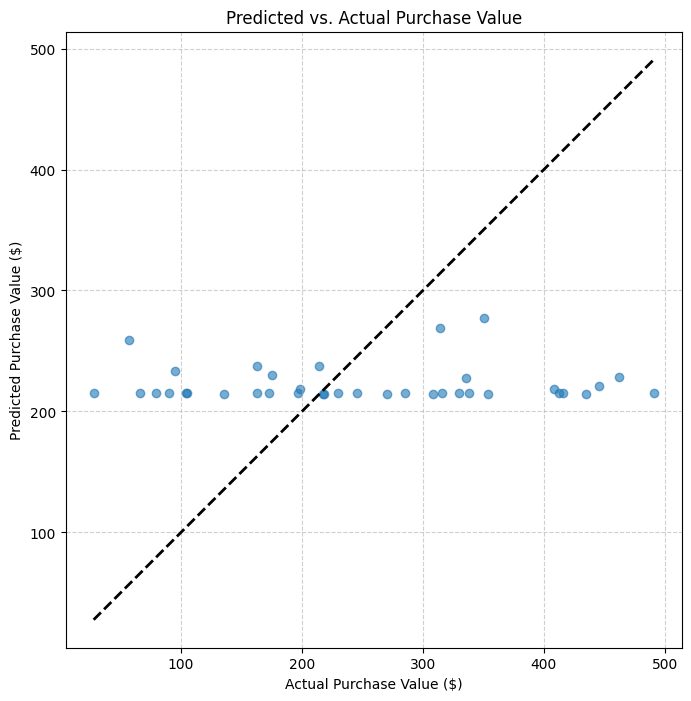

In [13]:
# --- Predicted vs. Actual Purchase Value (Test Set) ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel('Actual Purchase Value ($)')
plt.ylabel('Predicted Purchase Value ($)')
plt.title('Predicted vs. Actual Purchase Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box') # Make axes scales equal for a better visual comparison
plt.show()

--- Linear Regression Assumption Testing ---


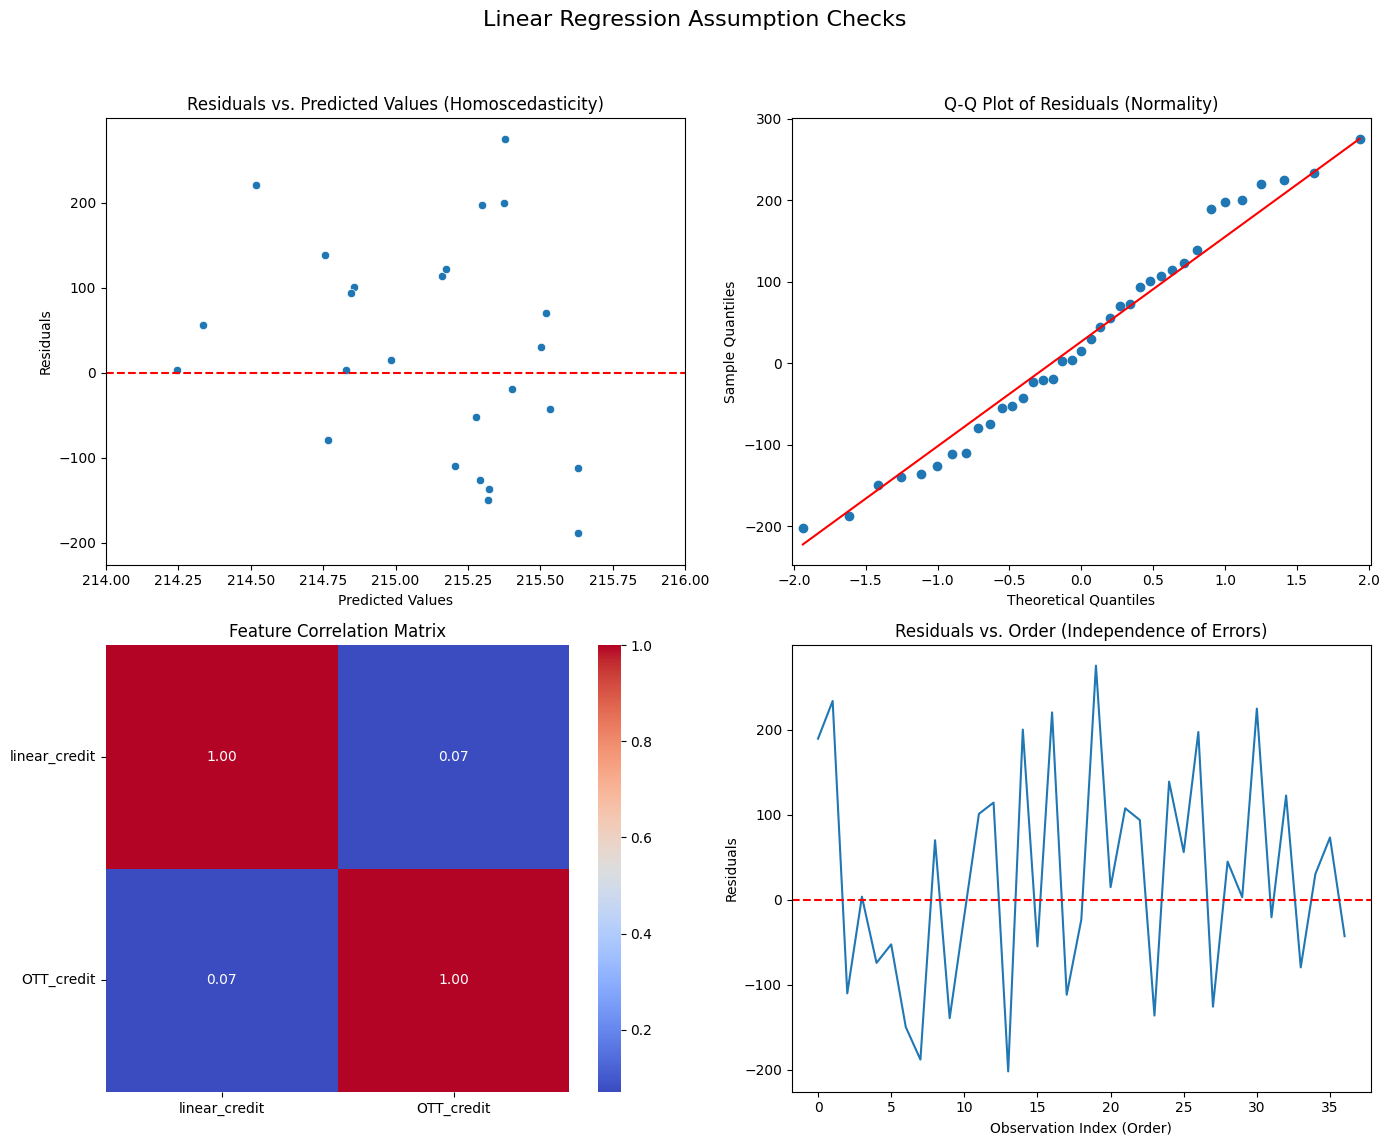

In [14]:
print("--- Linear Regression Assumption Testing ---")


residuals = y_test - y_pred_test

fig, axes = plt.subplots(2, 2, figsize=(14, 12)) # Create a 2x2 grid of subplots
fig.suptitle("Linear Regression Assumption Checks", fontsize=16)

# 1. Homoscedasticity: Residuals vs. Predicted Values
sns.scatterplot(x=y_pred_test, y=residuals, ax=axes[0, 0])
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel("Predicted Values")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].set_xlim(214, 216)
axes[0, 0].set_title("Residuals vs. Predicted Values (Homoscedasticity)")

# 2. Normality of Residuals: Q-Q Plot
sm.qqplot(residuals, line='s', ax=axes[0, 1]) # 's' for standardized line
axes[0, 1].set_title("Q-Q Plot of Residuals (Normality)")

# 3. Multicollinearity: Feature Correlation Matrix
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1, 0])
axes[1, 0].set_title("Feature Correlation Matrix")
shorter_labels = ['linear_credit', 'OTT_credit']
axes[1, 0].set_xticklabels(shorter_labels, rotation=0) # Rotate x-labels for better readability
axes[1, 0].set_yticklabels(shorter_labels)

# 4. Independence of Errors (Autocorrelation): Residuals vs. Order Plot
sns.lineplot(x=np.arange(len(residuals)), y=residuals, ax=axes[1, 1])
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_xlabel("Observation Index (Order)")
axes[1, 1].set_ylabel("Residuals")
axes[1, 1].set_title("Residuals vs. Order (Independence of Errors)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

- The top-left plot (Residuals vs Predicted Values) has a random-scatter shape and suggests that the model is homoscedastic since the errors are evenly distributed throughout the range of the predicted values.
- The top-right plot (Q-Q Plot) suggests that the residuals are normally distributed since the points follow a straight line.
- The bottom-left plot (Correlation Matrix) tells us that there is little to no multicollinearity to worry about since the correlations are close to 0.
- The bottom-right plot (Residuals vs. Order) flips flop often between points, which suggests that there shouldn't be a lot of dependence. If they were dependent, we would see clusters of points in positive or negative signs.